In [3]:
import random
import numpy as np
import pandas as pd
import altair as alt

# Base code for simulation testing

In [94]:
class BernoulliArm():
    def __init__(self, p):
        self.p = p
    
    # Reward system based on Bernoulli
    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0


In [95]:
def test_algorithm(algo, arms, num_sims, horizon):
    
    # Initialise variables for duration of accumulated simulation (num_sims * horizon_per_simulation)
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims *horizon)]
    times = [0.0 for i in range (num_sims*horizon)]
    
    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize(len(arms))
        
        for t in range(horizon):
            t = t + 1
            index = (sim -1) * horizon + t -1
            sim_nums[index] = sim
            times[index] = t
            
            # Selection of best arm and engaging it
            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm
            
            # Engage chosen Bernoulli Arm and obtain reward info
            reward = arms[chosen_arm].draw()
            rewards[index] = reward
            
            if t ==1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index-1] + reward
                
            algo.update(chosen_arm, reward)
    
    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

# Epsilon Greedy

In [2]:
class EpsilonGreedy():
    def __init__(self, epsilon, counts, values):
        self.epsilon = epsilon
        self.counts = counts # Count represent counts of pulls for each arm. For multiple arms, this will be a list of counts.
        self.values = values # Value represent average reward for specific arm. For multiple arms, this will be a list of values.
        return 
    
    # Initialise k number of arms
    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return
    
    # Epsilon greedy arm selection
    def select_arm(self):
        # If prob is not in epsilon, do exploitation of best arm so far
        if random.random() > self.epsilon:
            return np.argmax(self.values)
        # If prob falls in epsilon range, do exploration
        else:
            return random.randrange(len(self.values))
    
    # Choose to update chosen arm and reward
    def update(self, chosen_arm, reward):
        # update counts pulled for chosen arm
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        
        # Update average/mean value/reward for chosen arm
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return

In [53]:
import random

random.seed(1)
# out of 5 arms, 1 arm is clearly the best
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
# Shuffling arms
random.shuffle(means)

# Create list of Bernoulli Arms with Reward Information
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(np.argmax(means)))

f = open("standard_epsg_results.tsv", "w+")

# Create simulations for each exploration epsilon value
for epsilon in [0.1, 0.2, 0.3, 0.4, 0.5]:
    algo = EpsilonGreedy(epsilon, [], [])
    algo.initialize(n_arms)
    results = test_algorithm(algo, arms, 5000, 250)
    
    # Store data
    for i in range(len(results[0])):
        f.write(str(epsilon) + "\t")
        f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
f.close()
print("done")

Best arm is 2
done


In [54]:
df = pd.read_csv("standard_epsg_results.tsv", sep = "\t", header = None, names = ["epsilon", "simulation_num", "step", "chosen_arm", "reward", "cum_reward"])

df.head()

,epsilon,simulation_num,step,chosen_arm,reward,cum_reward
0,0.1,1,1,0,0.0,0.0
1,0.1,1,2,0,0.0,0.0
2,0.1,1,3,0,0.0,0.0
3,0.1,1,4,0,0.0,0.0
4,0.1,1,5,0,0.0,0.0


In [55]:
# Create a flag for each step to see if best arm was chosen
df["chose_correct"] = np.select(
    [
        df["chosen_arm"] == 2,
        df["chosen_arm"] != 2
    ],
    [
        1,
        0
    ]
)

In [56]:
# Perform average/mean for each step for all simulations and epsilon
df_chose_correctly = df.loc[:,["epsilon","step", "chose_correct"]].groupby(["epsilon","step"]).agg("mean")

# Remove multi index grouping
df_chose_correctly = df_chose_correctly.reset_index()

In [57]:
df_chose_correctly.head()

,epsilon,step,chose_correct
0,0.1,1,0.0184
1,0.1,2,0.0372
2,0.1,3,0.0514
3,0.1,4,0.0696
4,0.1,5,0.0822


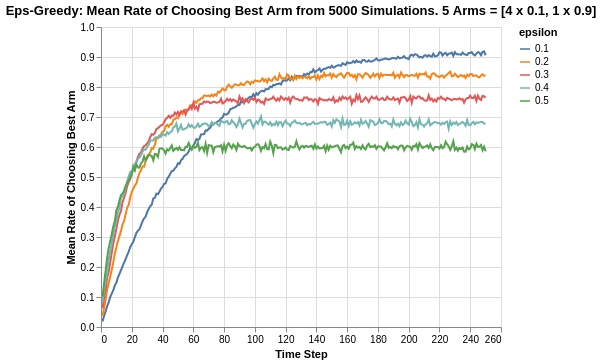

In [58]:
alt.Chart(df_chose_correctly).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("chose_correct:Q", title = "Mean Rate of Choosing Best Arm"),
    color = alt.Color("epsilon:N")
).properties(
    title = "Eps-Greedy: Mean Rate of Choosing Best Arm from 5000 Simulations. 5 Arms = [4 x 0.1, 1 x 0.9]",
)

In [59]:
df_cumreward = df.loc[:,["epsilon","step", "cum_reward"]].groupby(["epsilon","step"]).agg("mean").reset_index()

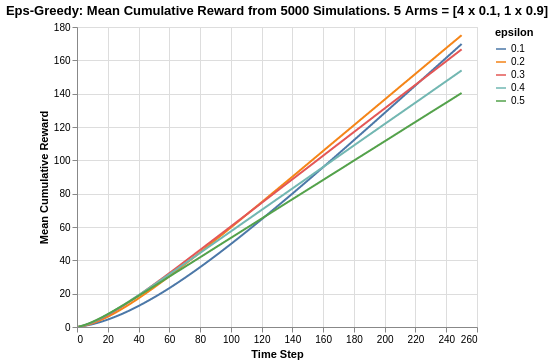

In [60]:
alt.Chart(df_cumreward).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("cum_reward:Q", title = "Mean Cumulative Reward"),
    color = alt.Color("epsilon:N")
).properties(
    title = "Eps-Greedy: Mean Cumulative Reward from 5000 Simulations. 5 Arms = [4 x 0.1, 1 x 0.9]",
)

In [13]:
import random

random.seed(1)
# out of 5 arms, 1 arm is clearly the best
means = [0.8, 0.8, 0.8, 0.8, 0.9]
n_arms = len(means)
# Shuffling arms
random.shuffle(means)

# Create list of Bernoulli Arms with Reward Information
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(np.argmax(means)))

f = open("standard_epsg_results1.tsv", "w+")

# Create simulations for each exploration epsilon value
for epsilon in [0.1, 0.2, 0.3, 0.4, 0.5]:
    algo = EpsilonGreedy(epsilon, [], [])
    algo.initialize(n_arms)
    results = test_algorithm(algo, arms, 5000, 250)
    
    # Store data
    for i in range(len(results[0])):
        f.write(str(epsilon) + "\t")
        f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
f.close()
print("done")

Best arm is 2
done


In [133]:
df = pd.read_csv("standard_epsg_results1.tsv", sep = "\t", header = None, names = ["epsilon", "simulation_num", "step", "chosen_arm", "reward", "cum_reward"])

df.head()

,epsilon,simulation_num,step,chosen_arm,reward,cum_reward
0,0.1,1,1,0,1.0,1.0
1,0.1,1,2,0,1.0,2.0
2,0.1,1,3,0,0.0,2.0
3,0.1,1,4,0,1.0,3.0
4,0.1,1,5,0,1.0,4.0


In [134]:
# Create a flag for each step to see if best arm was chosen
df["chose_correct"] = np.select(
    [
        df["chosen_arm"] == 2,
        df["chosen_arm"] != 2
    ],
    [
        1,
        0
    ]
)

In [135]:
# Perform average/mean for each step for all simulations and epsilon
df_chose_correctly = df.loc[:,["epsilon","step", "chose_correct"]].groupby(["epsilon","step"]).agg("mean")

# Remove multi index grouping
df_chose_correctly = df_chose_correctly.reset_index()

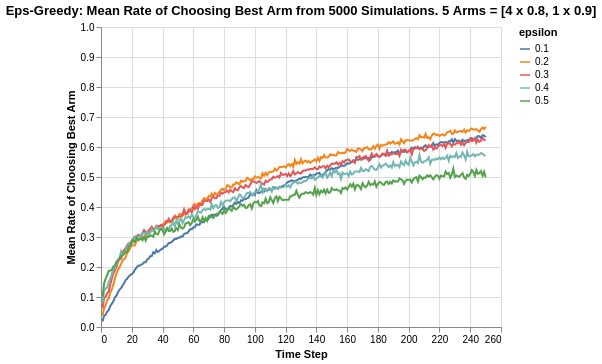

In [136]:
alt.Chart(df_chose_correctly).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("chose_correct:Q", title = "Mean Rate of Choosing Best Arm", scale = alt.Scale(domain = [0, 1])),
    color = alt.Color("epsilon:N")
).properties(
    title = "Eps-Greedy: Mean Rate of Choosing Best Arm from 5000 Simulations. 5 Arms = [4 x 0.8, 1 x 0.9]",
)

In [137]:
df_cumreward = df.loc[:,["epsilon","step", "cum_reward"]].groupby(["epsilon","step"]).agg("mean").reset_index()

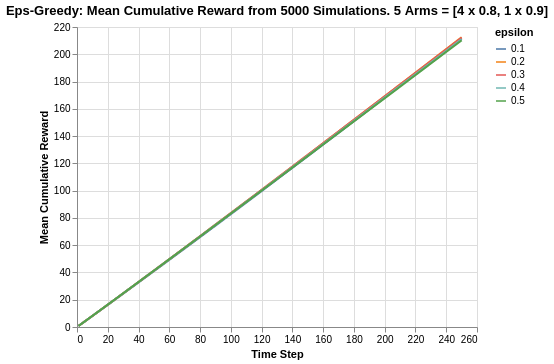

In [138]:
alt.Chart(df_cumreward).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("cum_reward:Q", title = "Mean Cumulative Reward"),
    color = alt.Color("epsilon:N")
).properties(
    title = "Eps-Greedy: Mean Cumulative Reward from 5000 Simulations. 5 Arms = [4 x 0.8, 1 x 0.9]",
)

In [141]:
df_cumreward

,epsilon,step,cum_reward,best_cumreward,regret
0,0.1,1,0.8068,0.9,0.0932
1,0.1,2,1.6090,1.8,0.1910
2,0.1,3,2.4140,2.7,0.2860
3,0.1,4,3.2246,3.6,0.3754
4,0.1,5,4.0266,4.5,0.4734
5,0.1,6,4.8282,5.4,0.5718
6,0.1,7,5.6382,6.3,0.6618
7,0.1,8,6.4462,7.2,0.7538
8,0.1,9,7.2602,8.1,0.8398
9,0.1,10,8.0644,9.0,0.9356


In [139]:
df_cumreward["best_cumreward"] = df["step"] * max(means)
df_cumreward["regret"] = df_cumreward["best_cumreward"]-  df_cumreward["cum_reward"]

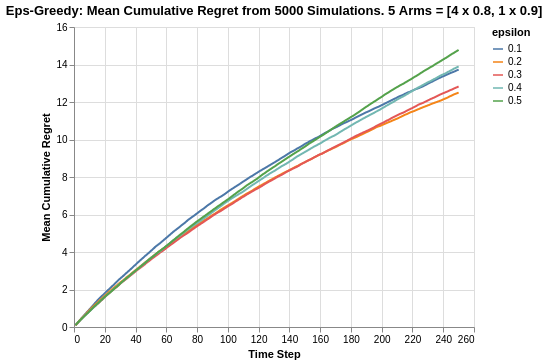

In [142]:
alt.Chart(df_cumreward).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("regret:Q", title = "Mean Cumulative Regret"),
    alt.Color("epsilon:N")
).properties(
    title = "Eps-Greedy: Mean Cumulative Regret from 5000 Simulations. 5 Arms = [4 x 0.8, 1 x 0.9]",
)

# Softmax Algorithm

In [20]:
import math
import random
def categorical_draw(probs):
    z = random.random()
    cum_prob = 0.0
    
    for i in range(len(probs)):
        prob = probs[i]
        cum_prob += prob
        
        if cum_prob > z:
            return i
    return len(probs) - 1


In [61]:
class Softmax:
    def __init__(self, tau, counts, values):
        self.tau = tau
        self.counts = counts
        self.values = values
        return
    
    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return
    
    def select_arm(self):
        z = sum([math.exp(v / self.tau) for v in self.values])
        probs = [math.exp(v / self.tau) / z for v in self.values]
        return categorical_draw(probs)
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return

In [62]:
import random

random.seed(1)
# out of 5 arms, 1 arm is clearly the best
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
# Shuffling arms
random.shuffle(means)

# Create list of Bernoulli Arms with Reward Information
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(np.argmax(means)))

f = open("standard_softmax_results.tsv", "w+")

# Create simulations for each tau/temperature value
for tau in [0.1, 0.2, 0.3, 0.4, 0.5]:
    algo = Softmax(tau, [], [])
    algo.initialize(n_arms)
    results = test_algorithm(algo, arms, 5000, 250)
    
    # Store data
    for i in range(len(results[0])):
        f.write(str(tau) + "\t")
        f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
f.close()
print("done")

Best arm is 2
done


In [63]:
df = pd.read_csv("standard_softmax_results.tsv", sep = "\t", header = None, names = ["tau", "simulation_num", "step", "chosen_arm", "reward", "cum_reward"])

df.head()

,tau,simulation_num,step,chosen_arm,reward,cum_reward
0,0.1,1,1,2,1.0,1.0
1,0.1,1,2,2,1.0,2.0
2,0.1,1,3,2,1.0,3.0
3,0.1,1,4,2,1.0,4.0
4,0.1,1,5,2,1.0,5.0


In [64]:
# Create a flag for each step to see if best arm was chosen
df["chose_correct"] = np.select(
    [
        df["chosen_arm"] == 2,
        df["chosen_arm"] != 2
    ],
    [
        1,
        0
    ]
)

In [65]:
# Perform average/mean for each step for all simulations and epsilon
df_chose_correctly = df.loc[:,["tau","step", "chose_correct"]].groupby(["tau","step"]).agg("mean")

# Remove multi index grouping
df_chose_correctly = df_chose_correctly.reset_index()

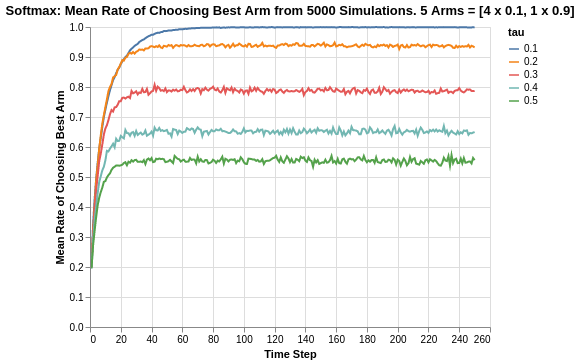

In [66]:
alt.Chart(df_chose_correctly).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("chose_correct:Q", title = "Mean Rate of Choosing Best Arm", scale = alt.Scale(domain = [0, 1])),
    color = alt.Color("tau:N")
).properties(
    title = "Softmax: Mean Rate of Choosing Best Arm from 5000 Simulations. 5 Arms = [4 x 0.1, 1 x 0.9]",
)

In [67]:
df_cumreward = df.loc[:,["tau","step", "cum_reward"]].groupby(["tau","step"]).agg("mean").reset_index()

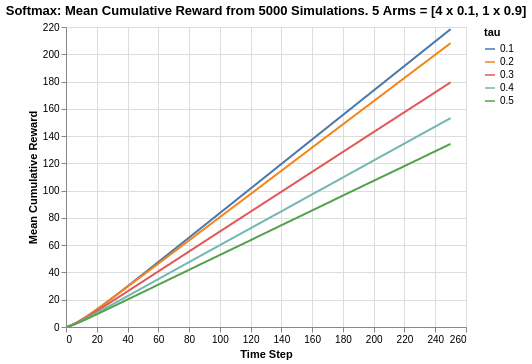

In [68]:
alt.Chart(df_cumreward).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("cum_reward:Q", title = "Mean Cumulative Reward"),
    color = alt.Color("tau:N")
).properties(
    title = "Softmax: Mean Cumulative Reward from 5000 Simulations. 5 Arms = [4 x 0.1, 1 x 0.9]",
)

In [69]:
import random

random.seed(1)
# out of 5 arms, 1 arm is clearly the best
means = [0.8, 0.8, 0.8, 0.8, 0.9]
n_arms = len(means)
# Shuffling arms
random.shuffle(means)

# Create list of Bernoulli Arms with Reward Information
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(np.argmax(means)))

f = open("standard_softmax_results1.tsv", "w+")

# Create simulations for each tau/temperature value
for tau in [0.1, 0.2, 0.3, 0.4, 0.5]:
    algo = Softmax(tau, [], [])
    algo.initialize(n_arms)
    results = test_algorithm(algo, arms, 5000, 250)
    
    # Store data
    for i in range(len(results[0])):
        f.write(str(tau) + "\t")
        f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
f.close()
print("done")

Best arm is 2
done


In [143]:
df = pd.read_csv("standard_softmax_results1.tsv", sep = "\t", header = None, names = ["tau", "simulation_num", "step", "chosen_arm", "reward", "cum_reward"])

df.head()

,tau,simulation_num,step,chosen_arm,reward,cum_reward
0,0.1,1,1,2,1.0,1.0
1,0.1,1,2,2,1.0,2.0
2,0.1,1,3,2,1.0,3.0
3,0.1,1,4,2,1.0,4.0
4,0.1,1,5,2,1.0,5.0


In [144]:
# Create a flag for each step to see if best arm was chosen
df["chose_correct"] = np.select(
    [
        df["chosen_arm"] == 2,
        df["chosen_arm"] != 2
    ],
    [
        1,
        0
    ]
)

In [145]:
# Perform average/mean for each step for all simulations and epsilon
df_chose_correctly = df.loc[:,["tau","step", "chose_correct"]].groupby(["tau","step"]).agg("mean")

# Remove multi index grouping
df_chose_correctly = df_chose_correctly.reset_index()

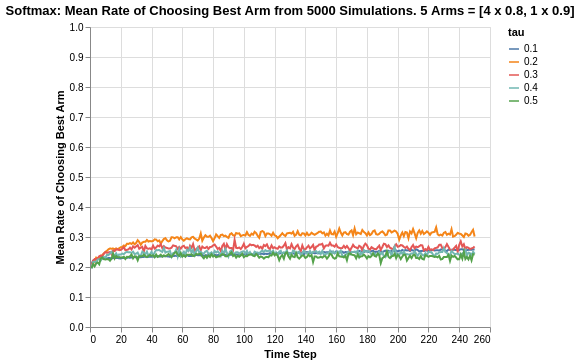

In [146]:
alt.Chart(df_chose_correctly).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("chose_correct:Q", title = "Mean Rate of Choosing Best Arm", scale = alt.Scale(domain = [0, 1])),
    color = alt.Color("tau:N")
).properties(
    title = "Softmax: Mean Rate of Choosing Best Arm from 5000 Simulations. 5 Arms = [4 x 0.8, 1 x 0.9]",
)

In [147]:
df_cumreward = df.loc[:,["tau","step", "cum_reward"]].groupby(["tau","step"]).agg("mean").reset_index()

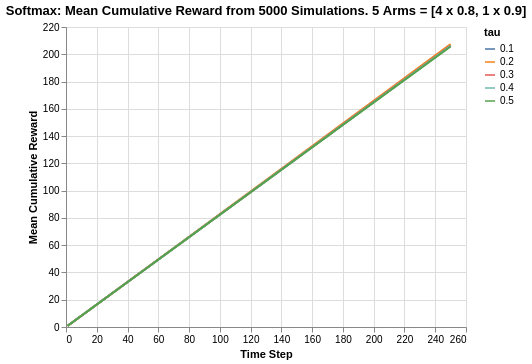

In [148]:
alt.Chart(df_cumreward).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("cum_reward:Q", title = "Mean Cumulative Reward"),
    color = alt.Color("tau:N")
).properties(
    title = "Softmax: Mean Cumulative Reward from 5000 Simulations. 5 Arms = [4 x 0.8, 1 x 0.9]",
)

In [149]:
df_cumreward["best_cumreward"] = df["step"] * max(means)
df_cumreward["regret"] = df_cumreward["best_cumreward"]-  df_cumreward["cum_reward"]

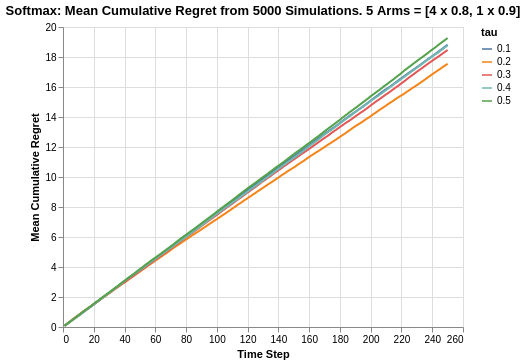

In [150]:
alt.Chart(df_cumreward).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("regret:Q", title = "Mean Cumulative Regret"), 
    alt.Color("tau:N")
).properties(
    title = "Softmax: Mean Cumulative Regret from 5000 Simulations. 5 Arms = [4 x 0.8, 1 x 0.9]",
)

# UCB 

In [36]:
class UCB1():
    def __init__(self, counts, values):
        self.counts = counts
        self.values = values
        return

    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return
    
    def select_arm(self):
        n_arms = len(self.counts)
        for arm in range(n_arms):
            if self.counts[arm] == 0:
                return arm
    
        ucb_values = [0.0 for arm in range(n_arms)]
        total_counts = sum(self.counts)
        
        for arm in range(n_arms):
            bonus = math.sqrt((2 * math.log(total_counts)) / float(self.counts[arm]))
            ucb_values[arm] = self.values[arm] + bonus
        return ucb_values.index(max(ucb_values))
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        return

In [37]:
import random

random.seed(1)
# out of 5 arms, 1 arm is clearly the best
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
# Shuffling arms
random.shuffle(means)

# Create list of Bernoulli Arms with Reward Information
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(np.argmax(means)))

f = open("standard_ucb_results.tsv", "w+")

# Create 1 round of 5000 simulations
algo = UCB1([], [])
algo.initialize(n_arms)
results = test_algorithm(algo, arms, 5000, 250)
    
# Store data
for i in range(len(results[0])):
    f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
f.close()
print("done")

Best arm is 2
done


In [38]:
df = pd.read_csv("standard_ucb_results.tsv", sep = "\t", header = None, names = ["simulation_num", "step", "chosen_arm", "reward", "cum_reward"])

df.head()

In [40]:
# Create a flag for each step to see if best arm was chosen
df["chose_correct"] = np.select(
    [
        df["chosen_arm"] == 2,
        df["chosen_arm"] != 2
    ],
    [
        1,
        0
    ]
)

In [41]:
# Perform average/mean for each step for all simulations and epsilon
df_chose_correctly = df.loc[:,["step", "chose_correct"]].groupby(["step"]).agg("mean")

# Remove multi index grouping
df_chose_correctly = df_chose_correctly.reset_index()

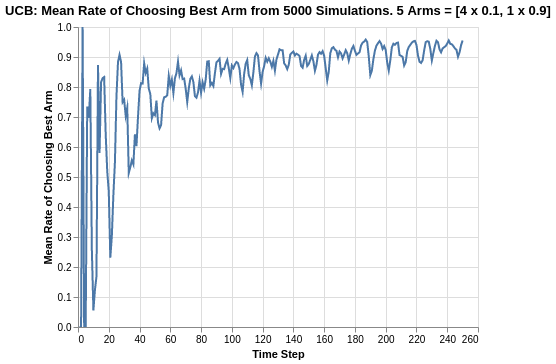

In [42]:
alt.Chart(df_chose_correctly).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("chose_correct:Q", title = "Mean Rate of Choosing Best Arm", scale = alt.Scale(domain = [0, 1])),
).properties(
    title = "UCB: Mean Rate of Choosing Best Arm from 5000 Simulations. 5 Arms = [4 x 0.1, 1 x 0.9]",
)

In [43]:
df_cumreward = df.loc[:,["step", "cum_reward"]].groupby(["step"]).agg("mean").reset_index()

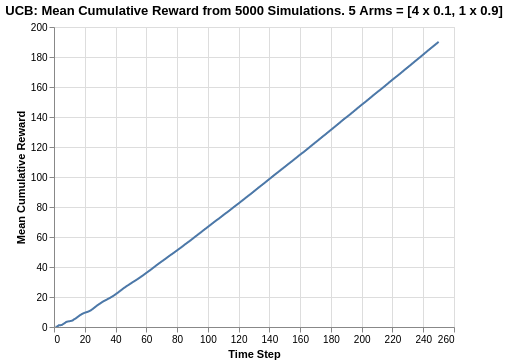

In [44]:
alt.Chart(df_cumreward).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("cum_reward:Q", title = "Mean Cumulative Reward")
).properties(
    title = "UCB: Mean Cumulative Reward from 5000 Simulations. 5 Arms = [4 x 0.1, 1 x 0.9]",
)

In [45]:
import random

random.seed(1)
# out of 5 arms, 1 arm is clearly the best
means = [0.8, 0.8, 0.8, 0.8, 0.9]
n_arms = len(means)
# Shuffling arms
random.shuffle(means)

# Create list of Bernoulli Arms with Reward Information
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(np.argmax(means)))

f = open("standard_ucb_results1.tsv", "w+")

# Create simulations for each exploration epsilon value
algo = UCB1([], [])
algo.initialize(n_arms)
results = test_algorithm(algo, arms, 5000, 250)
    
# Store data
for i in range(len(results[0])):
    f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
f.close()
print("done")

Best arm is 2
done


In [159]:
df = pd.read_csv("standard_ucb_results1.tsv", sep = "\t", header = None, names = ["simulation_num", "step", "chosen_arm", "reward", "cum_reward"])

df.head()

,simulation_num,step,chosen_arm,reward,cum_reward
0,1,1,0,1.0,1.0
1,1,2,1,1.0,2.0
2,1,3,2,1.0,3.0
3,1,4,3,1.0,4.0
4,1,5,4,1.0,5.0


In [160]:
# Create a flag for each step to see if best arm was chosen
df["chose_correct"] = np.select(
    [
        df["chosen_arm"] == 2,
        df["chosen_arm"] != 2
    ],
    [
        1,
        0
    ]
)

In [161]:
# Perform average/mean for each step for all simulations and epsilon
df_chose_correctly = df.loc[:,["step", "chose_correct"]].groupby(["step"]).agg("mean")

# Remove multi index grouping
df_chose_correctly = df_chose_correctly.reset_index()

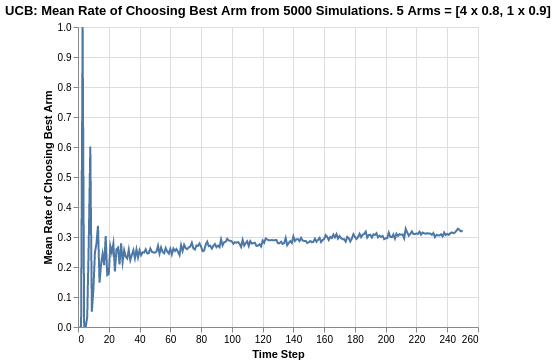

In [162]:
alt.Chart(df_chose_correctly).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("chose_correct:Q", title = "Mean Rate of Choosing Best Arm", scale = alt.Scale(domain = [0, 1])),
).properties(
    title = "UCB: Mean Rate of Choosing Best Arm from 5000 Simulations. 5 Arms = [4 x 0.8, 1 x 0.9]",
)

In [163]:
df_cumreward = df.loc[:,["step", "cum_reward"]].groupby(["step"]).agg("mean").reset_index()

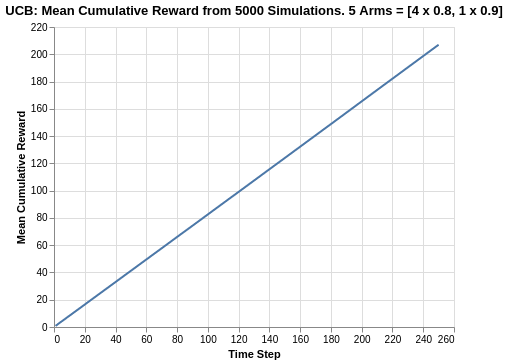

In [164]:
alt.Chart(df_cumreward).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("cum_reward:Q", title = "Mean Cumulative Reward")
).properties(
    title = "UCB: Mean Cumulative Reward from 5000 Simulations. 5 Arms = [4 x 0.8, 1 x 0.9]",
)

In [165]:
df_cumreward["best_cumreward"] = df["step"] * max(means)
df_cumreward["regret"] = df_cumreward["best_cumreward"]-  df_cumreward["cum_reward"]

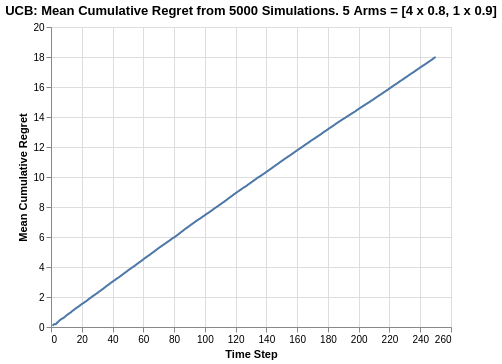

In [166]:
alt.Chart(df_cumreward).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("regret:Q", title = "Mean Cumulative Regret")
).properties(
    title = "UCB: Mean Cumulative Regret from 5000 Simulations. 5 Arms = [4 x 0.8, 1 x 0.9]",
)

# Thompson Sampling

In [7]:
from scipy.stats import beta

In [167]:
class ThompsonSampling():
    def __init__(self, counts, values, a, b):
        self.counts = counts
        self.values = values
        
        # Beta parameters
        self.a = a
        self.b = b
        return

    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]

        # Uniform distribution of prior beta (A,B)
        self.a = [1 for arm in range(n_arms)]
        self.b = [1 for arm in range(n_arms)]
        return
    
    def select_arm(self):
        n_arms = len(self.counts)
        
        # Pair up all beta params of a and b for each arm
        beta_params = zip(self.a, self.b)
        
        # Perform random draw for all arms based on their params (a,b)
        all_draws = [beta.rvs(i[0], i[1], size = 1) for i in beta_params]
        
        # return index of arm with the highest draw
        return all_draws.index(max(all_draws))
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        
        # Update a and b
        
        # a is based on total counts of rewards of arm
        self.a[chosen_arm] = self.a[chosen_arm] + reward
        
        # b is based on total counts of failed rewards on arm
        self.b[chosen_arm] = self.b[chosen_arm] + (1-reward)
        
        return

In [168]:
import random

random.seed(1)
# out of 5 arms, 1 arm is clearly the best
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
# Shuffling arms
random.shuffle(means)

# Create list of Bernoulli Arms with Reward Information
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(np.argmax(means)))

f = open("standard_ts_results.tsv", "w+")

# Create simulations for each exploration epsilon value
algo = ThompsonSampling([], [], [], [])
algo.initialize(n_arms)
results = test_algorithm(algo, arms, 5000, 250)
    
# Store data
for i in range(len(results[0])):
    f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
f.close()
print("done")

Best arm is 2
done


In [169]:
df = pd.read_csv("standard_ts_results.tsv", sep = "\t", header = None, names = ["simulation_num", "step", "chosen_arm", "reward", "cum_reward"])

df.head()

,simulation_num,step,chosen_arm,reward,cum_reward
0,1,1,1,0.0,0.0
1,1,2,2,1.0,1.0
2,1,3,2,1.0,2.0
3,1,4,3,0.0,2.0
4,1,5,2,1.0,3.0


In [170]:
# Create a flag for each step to see if best arm was chosen
df["chose_correct"] = np.select(
    [
        df["chosen_arm"] == 2,
        df["chosen_arm"] != 2
    ],
    [
        1,
        0
    ]
)

In [171]:
# Perform average/mean for each step for all simulations and epsilon
df_chose_correctly = df.loc[:,["step", "chose_correct"]].groupby(["step"]).agg("mean")

# Remove multi index grouping
df_chose_correctly = df_chose_correctly.reset_index()

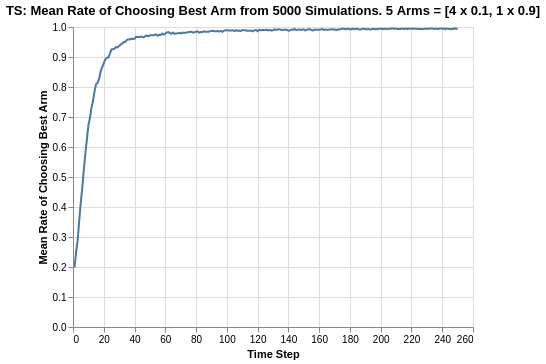

In [172]:
alt.Chart(df_chose_correctly).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("chose_correct:Q", title = "Mean Rate of Choosing Best Arm", scale = alt.Scale(domain = [0, 1])),
).properties(
    title = "TS: Mean Rate of Choosing Best Arm from 5000 Simulations. 5 Arms = [4 x 0.1, 1 x 0.9]",
)

In [173]:
df_cumreward = df.loc[:,["step", "cum_reward"]].groupby(["step"]).agg("mean").reset_index()

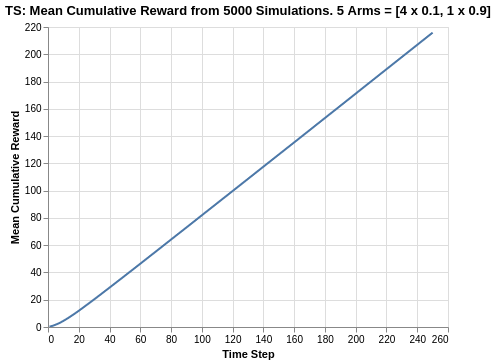

In [174]:
alt.Chart(df_cumreward).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("cum_reward:Q", title = "Mean Cumulative Reward")
).properties(
    title = "TS: Mean Cumulative Reward from 5000 Simulations. 5 Arms = [4 x 0.1, 1 x 0.9]",
)

In [175]:
import random

random.seed(1)
# out of 5 arms, 1 arm is clearly the best
means = [0.8, 0.8, 0.8, 0.8, 0.9]
n_arms = len(means)
# Shuffling arms
random.shuffle(means)

# Create list of Bernoulli Arms with Reward Information
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(np.argmax(means)))

f = open("standard_ts_results1.tsv", "w+")

# Create simulations for each exploration epsilon value
algo = ThompsonSampling([], [], [], [])
algo.initialize(n_arms)
results = test_algorithm(algo, arms, 5000, 250)
    
# Store data
for i in range(len(results[0])):
    f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
f.close()
print("done")

Best arm is 2
done


In [176]:
df = pd.read_csv("standard_ts_results1.tsv", sep = "\t", header = None, names = ["simulation_num", "step", "chosen_arm", "reward", "cum_reward"])

df.head()

,simulation_num,step,chosen_arm,reward,cum_reward
0,1,1,3,1.0,1.0
1,1,2,1,1.0,2.0
2,1,3,4,1.0,3.0
3,1,4,3,1.0,4.0
4,1,5,1,1.0,5.0


In [177]:
# Create a flag for each step to see if best arm was chosen
df["chose_correct"] = np.select(
    [
        df["chosen_arm"] == 2,
        df["chosen_arm"] != 2
    ],
    [
        1,
        0
    ]
)

In [178]:
# Perform average/mean for each step for all simulations and epsilon
df_chose_correctly = df.loc[:,["step", "chose_correct"]].groupby(["step"]).agg("mean")

# Remove multi index grouping
df_chose_correctly = df_chose_correctly.reset_index()

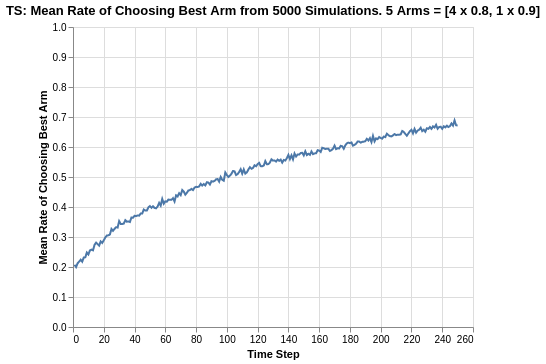

In [179]:
alt.Chart(df_chose_correctly).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("chose_correct:Q", title = "Mean Rate of Choosing Best Arm", scale = alt.Scale(domain = [0, 1])),
).properties(
    title = "TS: Mean Rate of Choosing Best Arm from 5000 Simulations. 5 Arms = [4 x 0.8, 1 x 0.9]",
)

In [180]:
df_cumreward = df.loc[:,["step", "cum_reward"]].groupby(["step"]).agg("mean").reset_index()

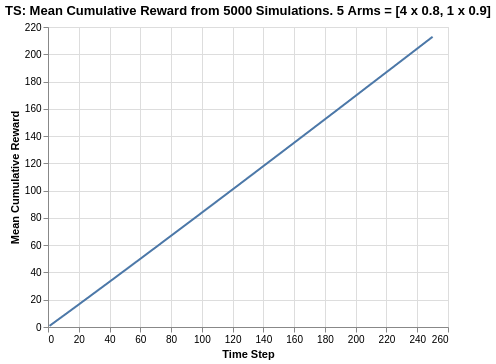

In [181]:
alt.Chart(df_cumreward).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("cum_reward:Q", title = "Mean Cumulative Reward")
).properties(
    title = "TS: Mean Cumulative Reward from 5000 Simulations. 5 Arms = [4 x 0.8, 1 x 0.9]",
)

In [182]:
df_cumreward["best_cumreward"] = df["step"] * max(means)
df_cumreward["regret"] = df_cumreward["best_cumreward"]-  df_cumreward["cum_reward"]

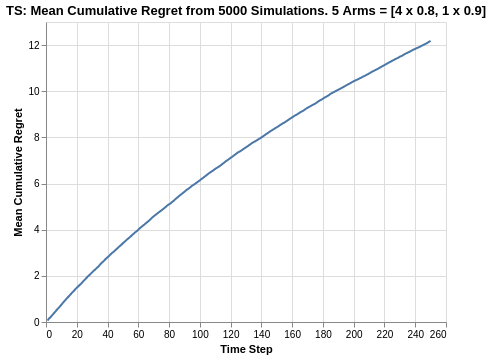

In [183]:
alt.Chart(df_cumreward).mark_line().encode(
    alt.X("step:Q", title = "Time Step"),
    alt.Y("regret:Q", title = "Mean Cumulative Regret")
).properties(
    title = "TS: Mean Cumulative Regret from 5000 Simulations. 5 Arms = [4 x 0.8, 1 x 0.9]",
)